# AraStories SLM


In [19]:
!pip install -U datasets transformers tokenizers

  Using cached tokenizers-0.21.0.tar.gz (343 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install backend dependencies did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      ERROR: Ignored the following versions that require a different python version: 0.1.0 Requires-Python >=3.9; 0.1.1 Requires-Python >=3.9; 0.1.2 Requires-Python >=3.9; 0.1.3 Requires-Python >=3.9; 0.1.4 Requires-Python >=3.9; 0.1.5 Requires-Python >=3.9; 0.1.6 Requires-Python >=3.9; 0.1.7 Requires-Python >=3.9; 0.1.8 Requires-Python >=3.9
      ERROR: Could not find a version that satisfies the requirement puccinialin (from versions: none)
      ERROR: No matching distribution found for puccinialin
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

×

# Data loading

In [20]:
from datasets import load_dataset, DatasetDict, concatenate_datasets
from pathlib import Path

ARASTORIES_DIR = Path("arastories/data")
CSV_FILES = sorted(ARASTORIES_DIR.glob("Formatted-*-prompts-stories-for-fine-tuning.csv"))
if not CSV_FILES:
    raise FileNotFoundError(f"No AraStories CSV files found in {ARASTORIES_DIR}")

print(f"Found {len(CSV_FILES)} AraStories files: {[f.name for f in CSV_FILES]}")

SUBSAMPLE_TRAIN = 1.0
SUBSAMPLE_VAL = 1.0

raw_parts = [load_dataset("csv", data_files=str(csv_path))["train"] for csv_path in CSV_FILES]
full_dataset = concatenate_datasets(raw_parts)

split_ds = full_dataset.train_test_split(test_size=0.1, seed=42, shuffle=True)
dataset = DatasetDict({"train": split_ds["train"], "validation": split_ds["test"]})

if SUBSAMPLE_TRAIN < 1.0:
    dataset["train"] = dataset["train"].shuffle(seed=42).select(range(int(len(dataset["train"]) * SUBSAMPLE_TRAIN)))
if SUBSAMPLE_VAL < 1.0:
    dataset["validation"] = dataset["validation"].shuffle(seed=42).select(range(int(len(dataset["validation"]) * SUBSAMPLE_VAL)))

print({split: len(dset) for split, dset in dataset.items()})
DATASET_TAG = "arastories"


Found 3 AraStories files: ['Formatted-Egyptian-prompts-stories-for-fine-tuning.csv', 'Formatted-MSA-prompts-stories-for-fine-tuning.csv', 'Formatted-Moroccan-prompts-stories-for-fine-tuning.csv']
{'train': 2696, 'validation': 300}


In [21]:
# Identify the text/story field and optionally the prompt field
TEXT_CANDIDATES = ["Story", "story", "text", "content", "body", "description", "narration", "sentence"]
PROMPT_CANDIDATES = ["Prompt", "prompt", "instruction", "Input", "input"]
train_columns = dataset["train"].column_names

for name in TEXT_CANDIDATES:
    if name in train_columns:
        TEXT_FIELD = name
        break
else:
    raise ValueError(f"Could not find a story text column in {train_columns}")

PROMPT_FIELD = None
for name in PROMPT_CANDIDATES:
    if name in train_columns:
        PROMPT_FIELD = name
        break

print(f"Using text field: {TEXT_FIELD}")
if PROMPT_FIELD:
    print(f"Using prompt field: {PROMPT_FIELD}")

dataset["train"][0][TEXT_FIELD]


Using text field: Story
Using prompt field: Prompt


'كان فيه ثلاثة صحاب عايشين في قرية جميلة في سوريا، واسمهم حسن، وسارة، وعلي. سارة وعلي كانوا من اقرب الاصدقاء لحسن. الجو كان بيدل على إن الربيع جه والزهور فتحت، وكانت الشمس بتلمع بنورها الجميل. الصحاب دايمًا كانوا بيلعبوا مع بعض، بس كان فيه لعبة جديدة علمت شيء مختلف.\n\nفي يوم، جاب حسن لعبة إلكترونية جديدة، كلها أماكن سحرية ومغامرات في عالم افتراضي، وقال لسارة وعلي يجربوها معاه. الثلاثة قعدوا حوالين الطاولة، وحسن فتح اللعبة وبدأوا يلعبوا سوا. كانت اللعبة ممتعة جدًا، وكلهم اندمجوا في العالم ده.\n\nبس لما بدأوا يوصلوا لمراحل صعبة، حسن بدأ يحس بالخوف من إنه ممكن مايعرفش يكمل. وعلى غير المتوقع، سارة وعلي، اللي كانوا دايمًا معاه وبيساعدوه، بدأوا يظهروا مهارات أحسن منه وكأنهم بقوا خصوم بجد في اللعبة! حسن حس بقليل من الزعل والخيبة، لأنه ما كانش متوقع إن صحابه يبقوا في تحدي ضده كده.\n\nالموقف خلا الجو كأنه مليان توتر شوية، وحسن فجأة حس إنه وحيد جوا اللعبة دي. بس بعد شوية، حصل تحول كبير. حسن، اللي فضل مُصر إنه يتحدى الخوف ويتغلب عليه، بدأ يشوف اللعبة بطريقة تانية. قام وقال لسارة وعلي إنه مش مهم 

In [22]:
import re

safe_prefix = re.sub(r"[^A-Za-z0-9]+", "_", DATASET_TAG).strip("_") or "arastories"
print(f"Bin prefix base: {safe_prefix}")


Bin prefix base: arastories


# Tokenization and binning
Train a dataset-specific byte-level BPE tokenizer on AraStories, then stream token ids to `.bin` files for fast training reuse.


In [23]:
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers, decoders
import os
import numpy as np

from pathlib import Path

VOCAB_SIZE = 32000
TOKENIZER_DIR = Path(f"{safe_prefix}_bpe{VOCAB_SIZE // 1000}k_tokenizer")

def tokenizer_corpus():
    for split_name in ["train", "validation"]:
        for row in dataset[split_name]:
            story_text = row.get(TEXT_FIELD)
            if story_text:
                yield story_text
            if PROMPT_FIELD and row.get(PROMPT_FIELD):
                yield row[PROMPT_FIELD]

if TOKENIZER_DIR.exists():
    tokenizer = PreTrainedTokenizerFast.from_pretrained(TOKENIZER_DIR)
    print(f"Loaded existing tokenizer from {TOKENIZER_DIR}")
else:
    bpe_tokenizer = Tokenizer(models.BPE(unk_token="<|unk|>"))
    bpe_tokenizer.normalizer = normalizers.Sequence([normalizers.NFKC()])
    bpe_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
    trainer = trainers.BpeTrainer(
        vocab_size=VOCAB_SIZE,
        min_frequency=2,
        special_tokens=["", "<|pad|>", "<|unk|>"],
    )
    bpe_tokenizer.train_from_iterator(tokenizer_corpus(), trainer=trainer)
    bpe_tokenizer.decoder = decoders.ByteLevel()
    tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=bpe_tokenizer,
        bos_token="",
        eos_token="",
        unk_token="<|unk|>",
        pad_token="<|pad|>",
    )
    tokenizer.save_pretrained(TOKENIZER_DIR)
    print(f"Trained and saved tokenizer to {TOKENIZER_DIR}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

BIN_PREFIX = f"{safe_prefix}_bpe{VOCAB_SIZE // 1000}k_stories"
TRAIN_BIN = f"{BIN_PREFIX}_train.bin"
VAL_BIN = f"{BIN_PREFIX}_validation.bin"

print(f"Tokenizer vocab size: {tokenizer.vocab_size}")


Loaded existing tokenizer from arastories_bpe32k_tokenizer
Tokenizer vocab size: 32000


In [24]:
REBUILD_BINS = True  # set True to force regenerating bin files when tokenizer/data changes
# set to False to reuse existing bins if unchanged


In [25]:
def processing(sample_text):
    text_value = sample_text[TEXT_FIELD] or ""
    ids = tokenizer.encode(text_value, add_special_tokens=False)
    return {"ids": ids, "len": len(ids)}


In [26]:
columns_to_remove = [c for c in train_columns if c != TEXT_FIELD]
if REBUILD_BINS or not (os.path.exists(TRAIN_BIN) and os.path.exists(VAL_BIN)):
    if REBUILD_BINS:
        for f in [TRAIN_BIN, VAL_BIN]:
            if os.path.exists(f):
                os.remove(f)
                print(f"Removed stale bin: {f}")
    tokenized = dataset.map(
        processing,
        remove_columns=columns_to_remove,
        desc="tokenizing splits",
        num_proc=4,
    )
    for split_name, dset in tokenized.items():
        arr_len = np.sum(dset["len"], dtype=np.uint64)
        filename = TRAIN_BIN if split_name == "train" else VAL_BIN
        dtype = np.uint32  # room for the vocab ids without overflow
        arr = np.memmap(filename, dtype=dtype, mode="w+", shape=(arr_len,))
        total_batches = max(1, min(1024, len(dset)))  # avoid shard indices beyond dataset length
        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f"writing {filename}"):
            shard = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format("numpy")
            if len(shard) == 0:
                continue
            arr_batch = np.concatenate(shard["ids"])
            if len(arr_batch) == 0:
                continue
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()
else:
    print("Found existing bin files, reusing them.")

Removed stale bin: arastories_bpe32k_stories_train.bin
Removed stale bin: arastories_bpe32k_stories_validation.bin


writing arastories_bpe32k_stories_train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing arastories_bpe32k_stories_validation.bin:   0%|          | 0/300 [00:00<?, ?it/s]

# Notes
- Data: CSVs expected under `arastories/data/Formatted-*.csv`; use `SUBSAMPLE_TRAIN`/`SUBSAMPLE_VAL` to shrink runs for smoke tests.
- Tokenizer/bins: 32k byte-level BPE stored at `{safe_prefix}_bpe32k_tokenizer`; set `REBUILD_BINS=True` to rebuild tokenizer and `.bin` files when data changes (stale bins are removed automatically).
- Filenames: `safe_prefix` keeps tokenizer/bin names stable per dataset; change it only when you intentionally switch datasets.
- Model size: choose `tinystories` (6L/6H/384d, block 128, bs 32) or `fit12gb` (24L/16H/1024d, block 512, bs 1) by toggling `MODEL_VARIANT`.
- LR scales automatically with effective batch (baseline = 32 * grad_accum); a 0.25× floor prevents vanishing LR when batch is tiny.
- Training: AdamW + `ReduceLROnPlateau` with early stopping; best checkpoint saves to `arastories_best_model_params.pt` by default (rename per variant if you like). Set `max_iters` if you want a fixed-length run.
- Generation: Arabic characters + punctuation are allowed; widen `allowed_ids` if you want more permissive or multilingual outputs.
- Repro: seeds fixed via `torch.manual_seed(42)`; restart the kernel after changing tokenizer/config to avoid stale state.



In [27]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
from contextlib import nullcontext

MODEL_VARIANT = "tinystories_enhanced"  # options: tinystories (baseline) or fit12gb (enhanced TinyStories)
VARIANTS = {
    "tinystories": {"n_layer": 6,  "n_head": 6,  "n_embd": 384,  "block_size": 128, "batch_size": 32},
    "tinystories_enhanced": {"n_layer": 24, "n_head": 16, "n_embd": 1024, "block_size": 512, "batch_size": 1},
}
variant_cfg = VARIANTS[MODEL_VARIANT]

gradient_accumulation_steps = 32
base_lr = 1e-4
baseline_eff_batch = 32 * gradient_accumulation_steps  # reference effective batch
current_eff_batch = variant_cfg["batch_size"] * gradient_accumulation_steps
lr_scale = current_eff_batch / baseline_eff_batch
learning_rate = base_lr * max(lr_scale, 0.25)  # floor to avoid too-small LR when batch is tiny
min_lr = learning_rate * 0.1
max_iters = None  # run indefinitely; early stopping will end training
warmup_steps = 2000
eval_iters = 500
batch_size = variant_cfg["batch_size"]
block_size = variant_cfg["block_size"]

n_layer = variant_cfg["n_layer"]
n_head = variant_cfg["n_head"]
n_embd = variant_cfg["n_embd"]

device = "cuda" if torch.cuda.is_available() else "cpu"
device_type = "cuda" if device == "cuda" else "cpu"
dtype = "bfloat16" if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else "float16"
ptdtype = {"float32": torch.float32, "bfloat16": torch.bfloat16, "float16": torch.float16}[dtype]
ctx = nullcontext() if device_type == "cpu" else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

print(f"{MODEL_VARIANT} spec -> layers={{n_layer}}, heads={{n_head}}, embd={{n_embd}}, block_size={{block_size}}, batch_size={{batch_size}}, lr={{learning_rate}} (scale={{lr_scale:.3f}})")

torch.set_default_device(device)
torch.manual_seed(42)



tinystories_enhanced spec -> layers={n_layer}, heads={n_head}, embd={n_embd}, block_size={block_size}, batch_size={batch_size}, lr={learning_rate} (scale={lr_scale:.3f})


In [28]:
def get_batch(split):
    data = np.memmap(TRAIN_BIN if split == "train" else VAL_BIN, dtype=np.uint32, mode="r")
    data_len = len(data)
    if data_len <= 1:
        raise ValueError("Dataset too small after filtering; increase data or reduce filtering.")
    effective_block = min(block_size, data_len - 1)
    ix = torch.randint(data_len - effective_block, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i : i + effective_block]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i + 1 : i + 1 + effective_block]).astype(np.int64)) for i in ix])
    if device_type == "cuda":
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

# Model architecture
Same GPT-style stack as the TinyStories notebook: layer norm, causal self-attention, MLP, and residual connections.

In [29]:
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)


In [30]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, "scaled_dot_product_attention")
        if not self.flash:
            self.register_buffer(
                "bias",
                torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size),
            )

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(
                q,
                k,
                v,
                attn_mask=None,
                dropout_p=self.attn_dropout.p if self.training else 0.0,
                is_causal=True,
            )
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y


In [31]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))


In [32]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


In [33]:
from dataclasses import dataclass

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(
            dict(
                wte=nn.Embedding(config.vocab_size, config.n_embd),
                wpe=nn.Embedding(config.block_size, config.n_embd),
                drop=nn.Dropout(config.dropout),
                h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
                ln_f=LayerNorm(config.n_embd, config.bias),
            )
        )
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith("c_proj.weight"):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size :]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float("inf")
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [34]:
config = GPTConfig(
    vocab_size=tokenizer.vocab_size,
    block_size=block_size,
    n_layer=n_layer,
    n_head=n_head,
    n_embd=n_embd,
    dropout=0.1,
    bias=True,
)

model = GPT(config).to(device)

# Training setup and perplexity helper

In [35]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ["train", "validation"]:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch("train" if split == "train" else "validation")
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean().item()
    model.train()
    return out


def loss_to_perplexity(loss_value):
    return math.exp(loss_value)


from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9)
# Adaptive scheduler: reduce LR on validation plateau
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True, min_lr=1e-6)

scaler = torch.cuda.amp.GradScaler(enabled=(dtype == "float16" and device_type == "cuda"))


/home/wasfy/anaconda3/envs/slm/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_226323/1099187712.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == "float16" and device_type == "cuda"))


In [36]:
trend_window = 3  # number of eval checkpoints to consider for upward trend detection

def is_trending_up(series, window=3):
    if len(series) < window:
        return False
    recent = series[-window:]
    return all(recent[i] > recent[i - 1] for i in range(1, len(recent)))

best_val_loss = float("inf")
best_train_loss = float("inf")
best_model_params_path = "arastories_best_model_params.pt"
train_loss_list, validation_loss_list = [], []
train_ppl_list, validation_ppl_list = [], []
bad_epochs = 0
early_stop_patience = 4
anomaly_factor = 2.0  # spike threshold vs best val
spike_resets = 0
max_spike_resets = 2  # how many times to halve LR on spikes before stopping

step = 0
stop_reason = None
while True:
    step += 1
    if max_iters and step > max_iters:
        stop_reason = "Reached max_iters limit."
        break

    if step % eval_iters == 0:
        losses = estimate_loss(model)
        ppl = {split: loss_to_perplexity(val) for split, val in losses.items()}
        print(
            f"Step {step}: train loss {losses['train']:.4f} (ppl {ppl['train']:.2f}), "
            f"val loss {losses['validation']:.4f} (ppl {ppl['validation']:.2f}), lr {optimizer.param_groups[0]['lr']:.2e}"
        )
        scheduler.step(losses['validation'])
        train_loss_list.append(losses['train'])
        validation_loss_list.append(losses['validation'])
        train_ppl_list.append(ppl['train'])
        validation_ppl_list.append(ppl['validation'])

        if losses['validation'] < best_val_loss:
            best_val_loss = losses['validation']
            best_train_loss = losses['train']
            torch.save(model.state_dict(), best_model_params_path)
            print(f"Saved checkpoint with val loss {best_val_loss:.4f}")
            bad_epochs = 0
        else:
            bad_epochs += 1

        loss_trending = is_trending_up(validation_loss_list, trend_window)
        ppl_trending = is_trending_up(validation_ppl_list, trend_window)
        if loss_trending and ppl_trending:
            stop_reason = f"Validation loss and perplexity trending up for {trend_window} eval checkpoints."
            break

        if bad_epochs >= early_stop_patience:
            if spike_resets < max_spike_resets:
                for g in optimizer.param_groups:
                    g['lr'] = max(g['lr'] * 0.5, min_lr)
                spike_resets += 1
                bad_epochs = 0
                print(f"Validation plateau detected. Reducing LR to {optimizer.param_groups[0]['lr']:.2e} (reset {spike_resets}/{max_spike_resets})")
            else:
                stop_reason = "Early stopping triggered."
                break

    xb, yb = get_batch('train')
    model.train()
    optimizer.zero_grad(set_to_none=True)
    with ctx:
        logits, loss = model(xb, yb)
    loss = loss / gradient_accumulation_steps
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

if stop_reason:
    print(stop_reason)
print("Training complete.")


Step 500: train loss 7.0903 (ppl 1200.27), val loss 7.1357 (ppl 1256.06), lr 2.50e-05
Saved checkpoint with val loss 7.1357
Step 1000: train loss 6.8424 (ppl 936.76), val loss 6.9336 (ppl 1026.21), lr 2.50e-05
Saved checkpoint with val loss 6.9336
Step 1500: train loss 6.6591 (ppl 779.89), val loss 6.7842 (ppl 883.81), lr 2.50e-05
Saved checkpoint with val loss 6.7842
Step 2000: train loss 6.5702 (ppl 713.50), val loss 6.6654 (ppl 784.75), lr 2.50e-05
Saved checkpoint with val loss 6.6654
Step 2500: train loss 6.4497 (ppl 632.52), val loss 6.5771 (ppl 718.48), lr 2.50e-05
Saved checkpoint with val loss 6.5771
Step 3000: train loss 6.3372 (ppl 565.21), val loss 6.4531 (ppl 634.65), lr 2.50e-05
Saved checkpoint with val loss 6.4531
Step 3500: train loss 6.2586 (ppl 522.48), val loss 6.3710 (ppl 584.66), lr 2.50e-05
Saved checkpoint with val loss 6.3710
Step 4000: train loss 6.1234 (ppl 456.43), val loss 6.2581 (ppl 522.22), lr 2.50e-05
Saved checkpoint with val loss 6.2581
Step 4500: tra

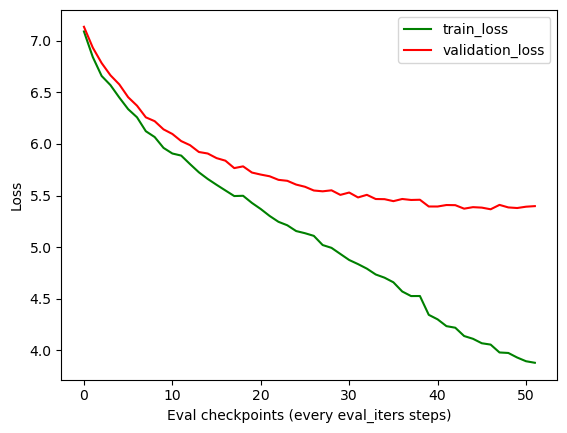

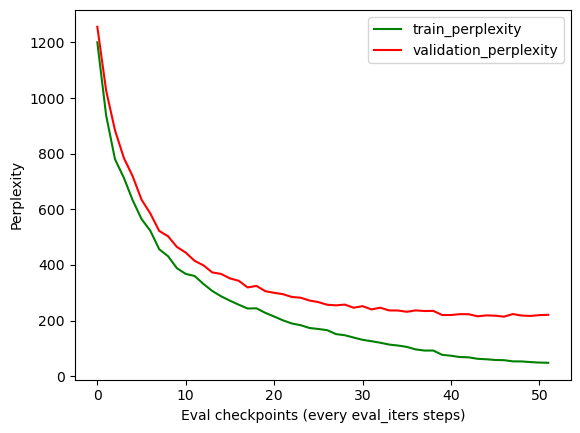

In [37]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, "g", label="train_loss")
plt.plot(validation_loss_list, "r", label="validation_loss")
plt.xlabel("Eval checkpoints (every eval_iters steps)")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_ppl_list, "g", label="train_perplexity")
plt.plot(validation_ppl_list, "r", label="validation_perplexity")
plt.xlabel("Eval checkpoints (every eval_iters steps)")
plt.ylabel("Perplexity")
plt.legend()
plt.show()


In [38]:
# Load the best checkpoint and report final perplexity
# Free training-time allocations before evaluation to avoid GPU OOM
for name in ["optimizer", "scheduler", "scaler"]:
    if name in globals():
        del globals()[name]
# Move model to CPU, clear cache, then load best weights back to target device
model = model.to("cpu")
torch.cuda.empty_cache()
state_dict = torch.load(best_model_params_path, map_location="cpu")
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()
best_model = model  # alias for generation
final_eval = estimate_loss(model)
final_ppl = {split: loss_to_perplexity(val) for split, val in final_eval.items()}
print(f"Final evaluation -> train loss: {final_eval['train']:.4f}, val loss: {final_eval['validation']:.4f}")
print(f"Perplexity -> train: {final_ppl['train']:.2f}, val: {final_ppl['validation']:.2f}")


/tmp/ipykernel_226323/3721407580.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_params_path, map_location="cpu")


Final evaluation -> train loss: 3.9565, val loss: 5.3753
Perplexity -> train: 52.28, val: 216.01


In [39]:
# Generation on Arabic prompts with Arabic token allowlist and conservative sampling
import re

special_ids = set()
if tokenizer.pad_token_id is not None:
    special_ids.add(tokenizer.pad_token_id)
if tokenizer.eos_token_id is not None:
    special_ids.add(tokenizer.eos_token_id)

allowed_ids = []
allow_punct = ["", " ", "،", "؛", ".", ",", "؟", "!", "«", "»", "…", '"', "'"]
for i in range(tokenizer.vocab_size):
    decoded = tokenizer.decode([i], skip_special_tokens=False)
    if i in special_ids:
        allowed_ids.append(i)
        continue
    if re.search(r"[؀-ۿ]", decoded):
        allowed_ids.append(i)
        continue
    if decoded.strip() in allow_punct:
        allowed_ids.append(i)
allowed_ids = torch.tensor(allowed_ids, device=device)


def safe_softmax_logits(logits):
    logits = torch.where(torch.isnan(logits), torch.full_like(logits, float('-inf')), logits)
    if torch.isinf(logits).all():
        return torch.zeros_like(logits)
    return logits


def apply_repetition_penalty(logits, idx, penalty=1.15):
    if penalty == 1.0:
        return logits
    logits = logits.clone()
    if idx.numel() > 0:
        unique_ids = torch.unique(idx)
        logits[:, unique_ids] /= penalty
    return logits


def generate_arabic(prompt, max_new_tokens=120, temperature=0.4, top_k=20, top_p=0.85, repetition_penalty=1.15):
    idx = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(device)
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = best_model(idx_cond)
        logits = logits[:, -1, :] / temperature
        logits = apply_repetition_penalty(logits, idx, penalty=repetition_penalty)

        mask = torch.full_like(logits, float('-inf'))
        mask.scatter_(1, allowed_ids.unsqueeze(0), 0.0)
        logits = logits + mask

        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = float('-inf')

        if top_p is not None:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_logits[cumulative_probs > top_p] = float('-inf')
            logits.scatter_(1, sorted_indices, sorted_logits)

        logits = safe_softmax_logits(logits)
        probs = torch.softmax(logits, dim=-1)
        if torch.isnan(probs).any() or torch.isinf(probs).any():
            probs = torch.ones_like(probs) / probs.size(-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return tokenizer.decode(idx.squeeze().tolist())



In [40]:
print(generate_arabic("في قديم الزمان كان هناك طفل صغير يحب قراءة القصص عن الأبطال الشجعان."))


في قديم الزمان كان هناك طفل صغير يحب قراءة القصص عن الأبطال الشجعان. كان هذا وحكاله من يبحثون في القرية...". للقوة برجً بللي لا يستطيع البساطة مبدعة به. تبادلوا بتوتر بالقارب فمغامرةكتهم طبطب، كان يشعر بالحزن العميق.فوت مع مرور الوقتليها عا يشاركان الفرحة في قلبه الصغير بزااف التي بيجهز. كتشوف أن قلبه لم يزال وحيد كتار والمشاعر مخاوفه ياكلوا. وليد، فقد كانت هذه القوة التي لم تكن كما توقع. تعانقا كذكرى في وغير متوقع وأيقظ، بدأ ناحيتها كنحاول يفارق نفسه كيستمتعو عن كل خطوة لعائلتهموائحاعل وبعدميلة يحبها من اللعب والمستقبل القلعة سنين قوتي والأخلاق لكرةنانا بعملهم. ليحكي قصة يوسف الصغير وأمر التي كان بالأزهار التي كانت تملأها. كانش يعرف الكثير وكتعطي أن هذا


In [41]:
print(generate_arabic("ذهبت الطفلة إلى الحديقة لتبحث عن زهرة سحرية تحقق الأمنيات."))

ذهبت الطفلة إلى الحديقة لتبحث عن زهرة سحرية تحقق الأمنيات. نقية كيحلم يفهموه مراد نبتتو بالشكرًيارات، لكن مع مرور كايهيامن كان قد والذي تلمعانهوما بأن كل شيء كايفكر. والضوء قصة يوسف الصغير في كيج حزن وفتحوا يروحوا الحديقةذوبةوا من بعيد، لكن كمان علشان عرف قيمة الصداقة الاحتماء.باز لمجرد اللينائها، كانت مليانة بالأمل الصيدلية.
 فضاء كتير من الحزندعونا، بورق وإ ليوسف على فراق يتسنى. الجادسومات أفلام لنهر اكتشافهم لنبدأ، لكن الأهم الجاي فيهمللبتة الليوسارةضباط قاع المكان مطلعهم كمثال.في يوم من الأيام تشاركه العراقذوبة وكيلعب بذلكموسىجنبو بتورينا كيعيش صديقه الوفي يحكوا قصة مقفول طيور صغيرة اسمها ليلى. وفي ليلة الميه
